In [1]:
library(data.table)
library(magrittr)
library(ggplot2)
library(scales)
library(stringr)
library(quanteda)

quanteda version 0.99.22
Using 3 of 4 threads for parallel computing

Attaching package: ‘quanteda’

The following object is masked from ‘jupyter:irkernel’:

    View

The following object is masked from ‘package:utils’:

    View



In [12]:
train <- fread('./train.tsv', showProgress = FALSE)
dim(train)

[1] 1482535       8

In [14]:
summary(train)

    train_id           name           item_condition_id category_name     
 Min.   :      0   Length:1482535     Min.   :1.000     Length:1482535    
 1st Qu.: 370634   Class :character   1st Qu.:1.000     Class :character  
 Median : 741267   Mode  :character   Median :2.000     Mode  :character  
 Mean   : 741267                      Mean   :1.907                       
 3rd Qu.:1111900                      3rd Qu.:3.000                       
 Max.   :1482534                      Max.   :5.000                       
  brand_name            price            shipping      item_description  
 Length:1482535     Min.   :   0.00   Min.   :0.0000   Length:1482535    
 Class :character   1st Qu.:  10.00   1st Qu.:0.0000   Class :character  
 Mode  :character   Median :  17.00   Median :0.0000   Mode  :character  
                    Mean   :  26.74   Mean   :0.4473                     
                    3rd Qu.:  29.00   3rd Qu.:1.0000                     
                    Max.   :200

In [15]:
str(train)

Classes ‘data.table’ and 'data.frame':	1482535 obs. of  8 variables:
 $ train_id         : int  0 1 2 3 4 5 6 7 8 9 ...
 $ name             : chr  "MLB Cincinnati Reds T Shirt Size XL" "Razer BlackWidow Chroma Keyboard" "AVA-VIV Blouse" "Leather Horse Statues" ...
 $ item_condition_id: int  3 3 1 1 1 3 3 3 3 3 ...
 $ category_name    : chr  "Men/Tops/T-shirts" "Electronics/Computers & Tablets/Components & Parts" "Women/Tops & Blouses/Blouse" "Home/Home Décor/Home Décor Accents" ...
 $ brand_name       : chr  "" "Razer" "Target" "" ...
 $ price            : num  10 52 10 35 44 59 64 6 19 8 ...
 $ shipping         : int  1 0 1 1 0 0 0 1 0 0 ...
 $ item_description : chr  "No description yet" "This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work"| __truncated__ "Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!" "New with tags. Leather horses. Retail for [r

# The Target

In [17]:
range(train$price)

[1]    0 2009

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


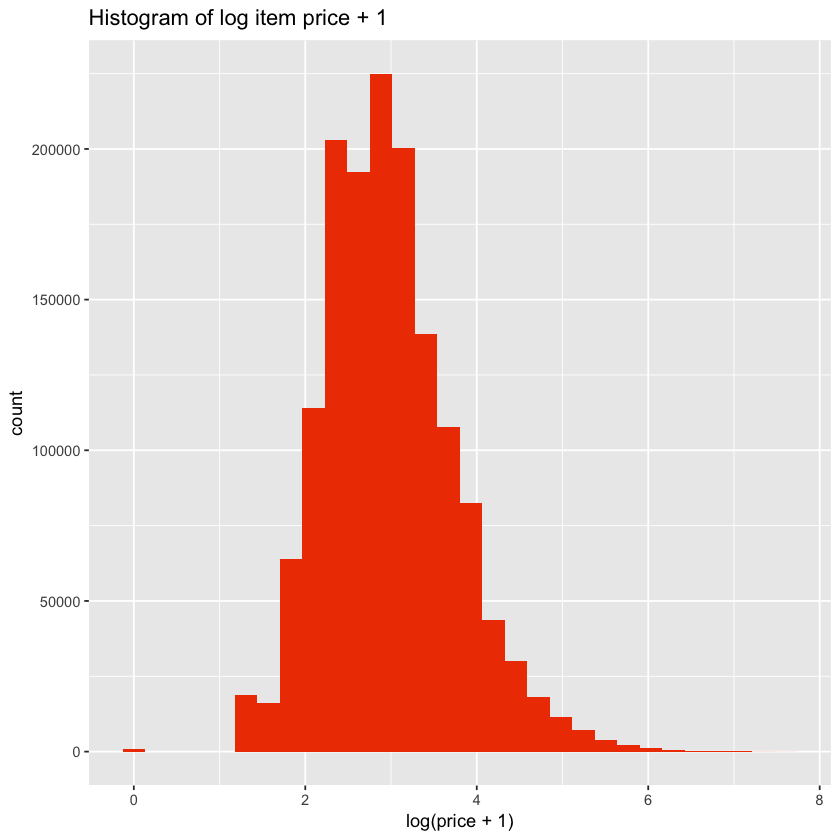

In [18]:
ggplot(data = train, aes(x = log(price+1))) + 
    geom_histogram(fill = 'orangered2') +
    labs(title = 'Histogram of log item price + 1')

In [19]:
table(train$item_condition_id)


     1      2      3      4      5 
640549 375479 432161  31962   2384 

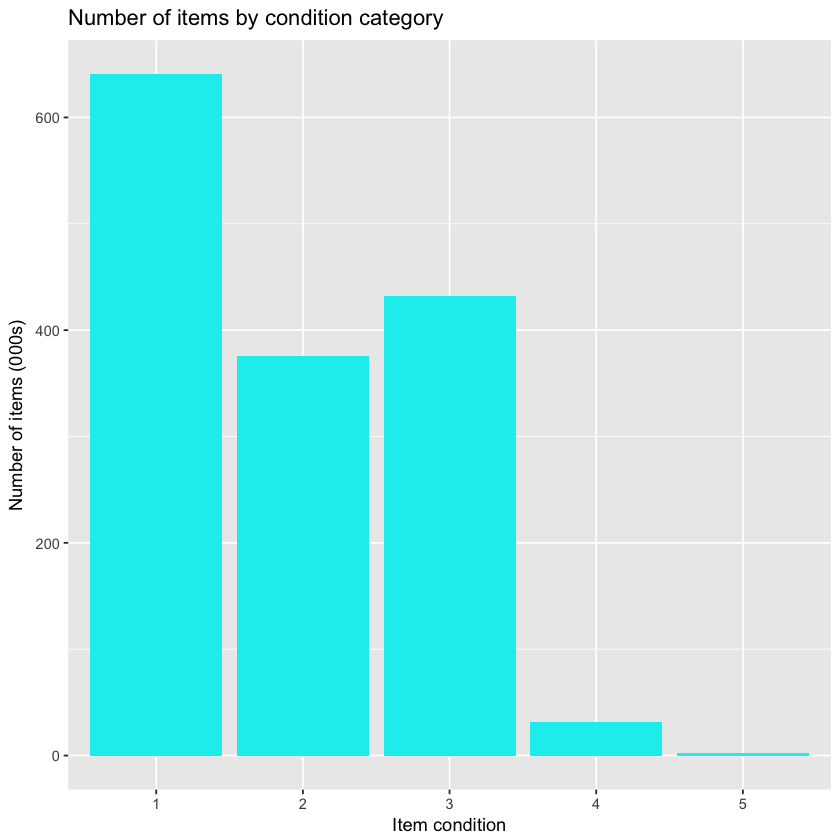

In [20]:
train[, .N, by = item_condition_id] %>%
    ggplot(aes(x = as.factor(item_condition_id), y = N/1000)) +
    geom_bar(stat = 'identity', fill = 'cyan2') + 
    labs(x = 'Item condition', y = 'Number of items (000s)', title = 'Number of items by condition category')

In [21]:
train[, .(.N, median(price)), by = item_condition_id][order(item_condition_id)]

item_condition_id,N,V2
1,640549,18
2,375479,17
3,432161,16
4,31962,15
5,2384,19


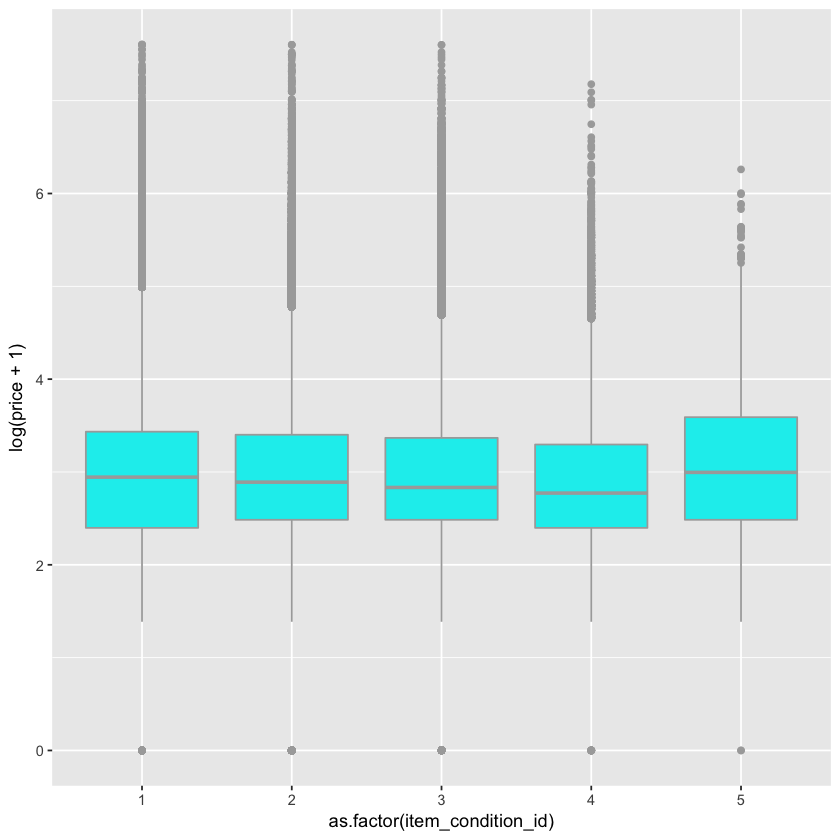

In [22]:
ggplot(data = train, aes(x = as.factor(item_condition_id), y = log(price + 1))) + 
    geom_boxplot(fill = 'cyan2', color = 'darkgrey')

# Shipping

In [23]:
table(train$shipping)


     0      1 
819435 663100 

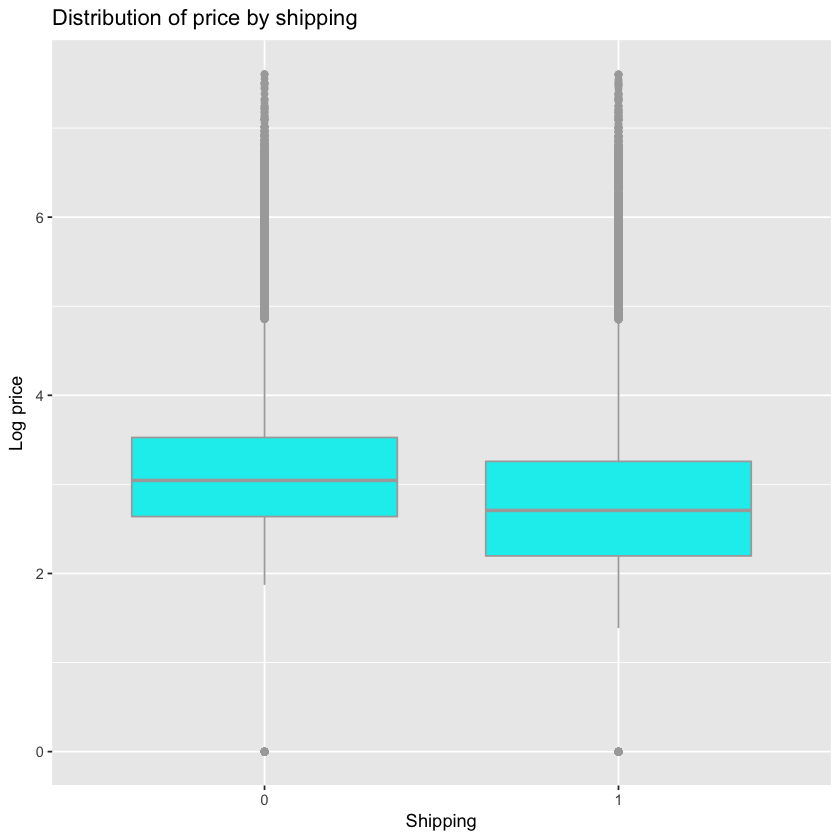

In [24]:
train %>%
    ggplot(aes(x = as.factor(shipping), y = log(price+1))) + 
    geom_boxplot(fill = 'cyan2', color = 'darkgrey') + 
    labs(x = 'Shipping', y = 'Log price', title = 'Distribution of price by shipping')

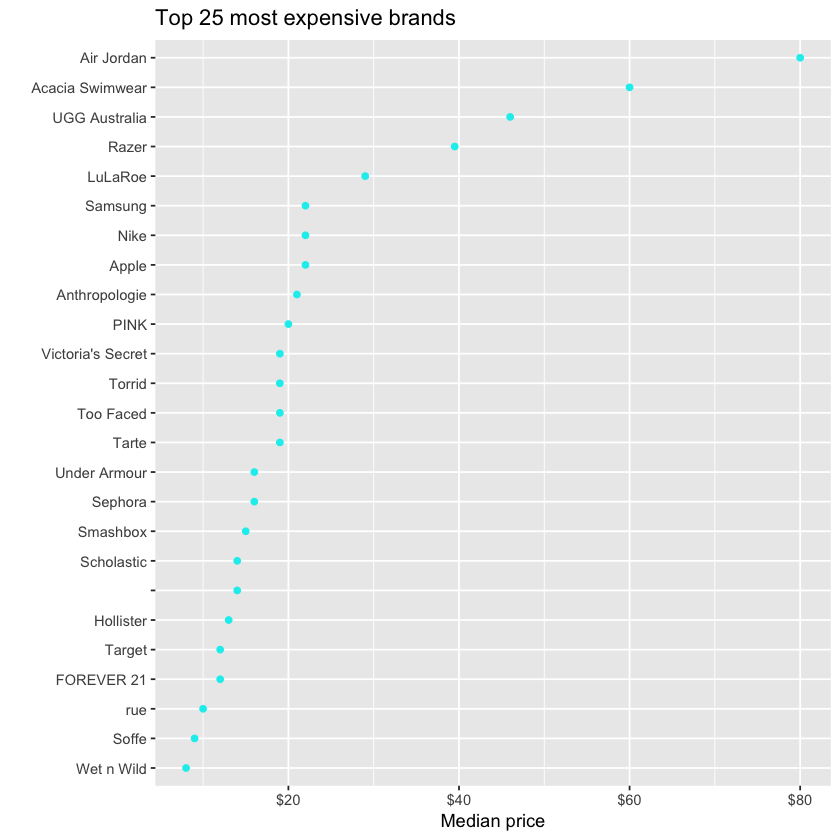

In [25]:
train[, .(median_price = median(price)), by = brand_name] %>%
    head(25) %>%
    ggplot(aes(x = reorder(brand_name, median_price), y = median_price)) + 
    geom_point(color = 'cyan2') + 
    scale_y_continuous(labels = scales::dollar) + 
    coord_flip() +
    labs(x = '', y = 'Median price', title = 'Top 25 most expensive brands') 

# Item Categories

In [26]:
length(unique(train$category_name))

[1] 1288

In [27]:
sort(table(train$category_name), decreasing = TRUE)[1:10]


             Women/Athletic Apparel/Pants, Tights, Leggings 
                                                      60177 
                              Women/Tops & Blouses/T-Shirts 
                                                      46380 
                                         Beauty/Makeup/Face 
                                                      34335 
                                         Beauty/Makeup/Lips 
                                                      29910 
                   Electronics/Video Games & Consoles/Games 
                                                      26557 
                                         Beauty/Makeup/Eyes 
                                                      25215 
Electronics/Cell Phones & Accessories/Cases, Covers & Skins 
                                                      24676 
                                       Women/Underwear/Bras 
                                                      21274 
                       

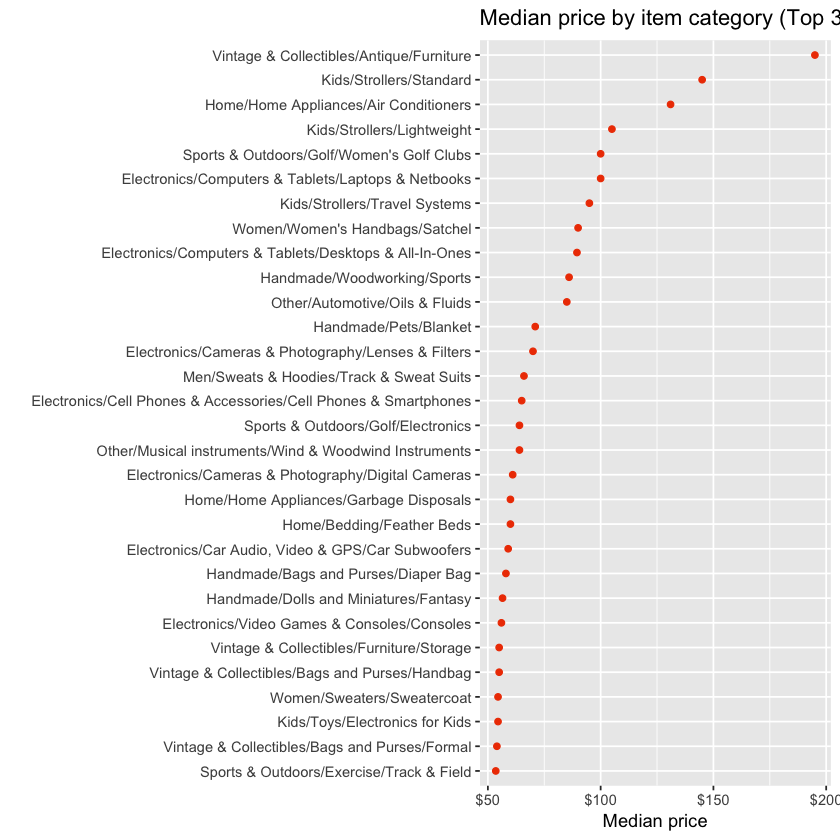

In [28]:
train[, .(median = median(price)), by = category_name][order(median, decreasing = TRUE)][1:30] %>%
    ggplot(aes(x = reorder(category_name, median), y = median)) + 
    geom_point(color = 'orangered2') + 
    coord_flip() + 
    labs(x = '', y = 'Median price', title = 'Median price by item category (Top 30)') + 
    scale_y_continuous(labels = scales::dollar)

In [29]:
# split the item category_name by '/' and get the first two category levels as separate columns
train[, c("level_1_cat", "level_2_cat") := tstrsplit(train$category_name, split = "/", keep = c(1,2))]

# peek at the first few rows to make sure this worked correctly. 
head(train[, c("level_1_cat", "level_2_cat")])

level_1_cat,level_2_cat
Men,Tops
Electronics,Computers & Tablets
Women,Tops & Blouses
Home,Home Décor
Women,Jewelry
Women,Other


In [30]:
table(train$level_1_cat)


                Beauty            Electronics               Handmade 
                207828                 122690                  30842 
                  Home                   Kids                    Men 
                 67871                 171689                  93680 
                 Other      Sports & Outdoors Vintage & Collectibles 
                 45351                  25342                  46530 
                 Women 
                664385 

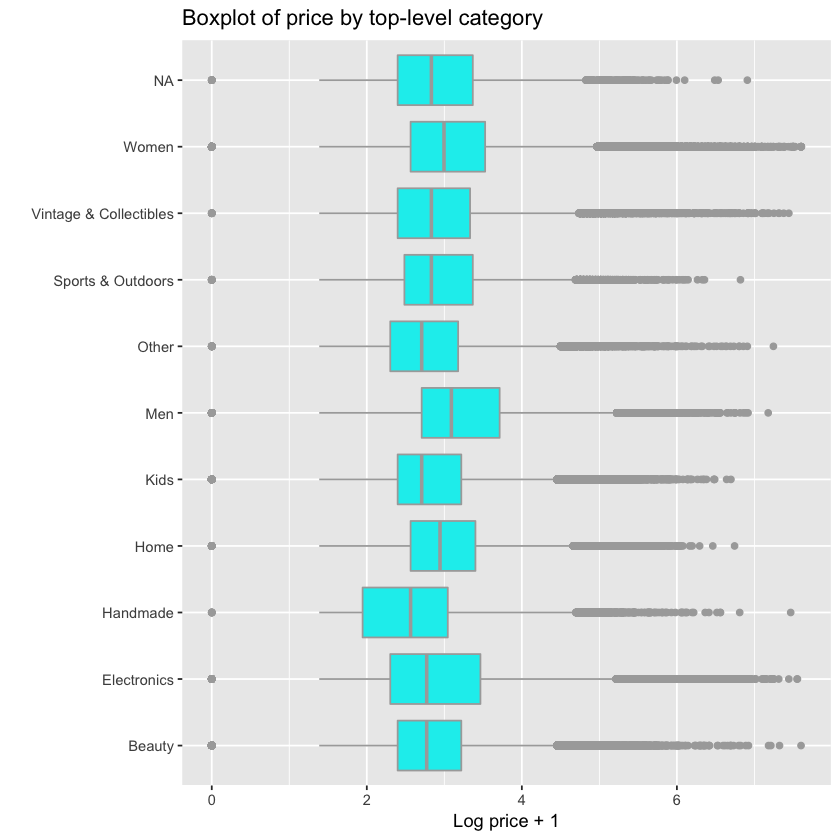

In [31]:
train %>%
    ggplot(aes(x = level_1_cat, y = log(price+1))) + 
    geom_boxplot(fill = 'cyan2', color = 'darkgrey') + 
    coord_flip() + 
    labs(x = '', y = 'Log price + 1', title = 'Boxplot of price by top-level category')

In [32]:
# get number of unique level 2 categories
length(unique(train$level_2_cat))

[1] 114

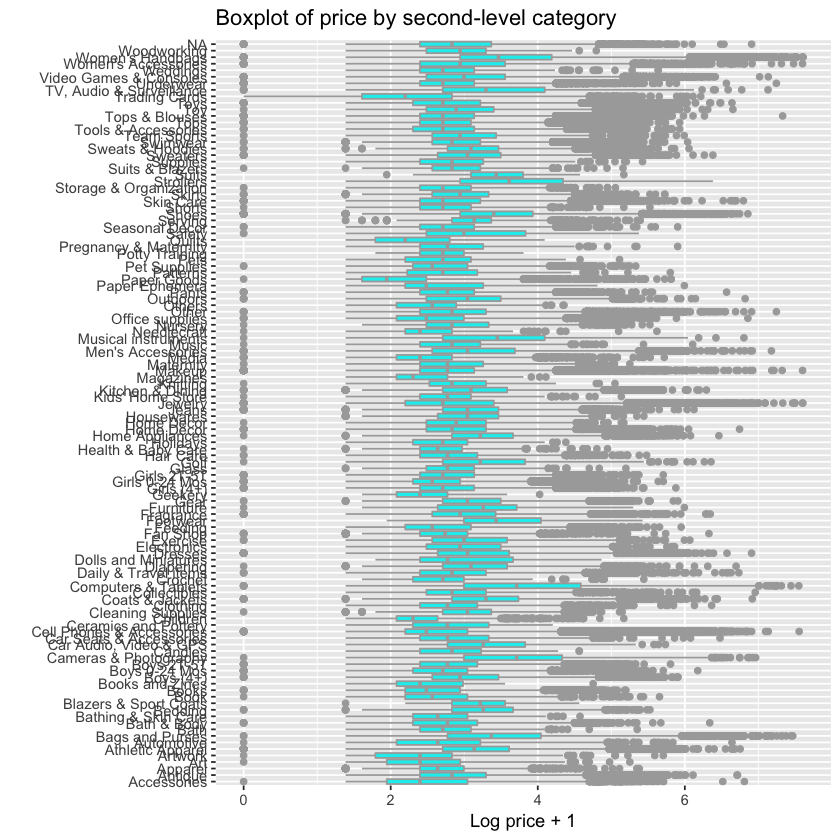

In [33]:
train %>%
    ggplot(aes(x = level_2_cat, y = log(price+1))) + 
    geom_boxplot(fill = 'cyan2', color = 'darkgrey') + 
    coord_flip() + 
    labs(x = '', y = 'Log price + 1', title = 'Boxplot of price by second-level category')

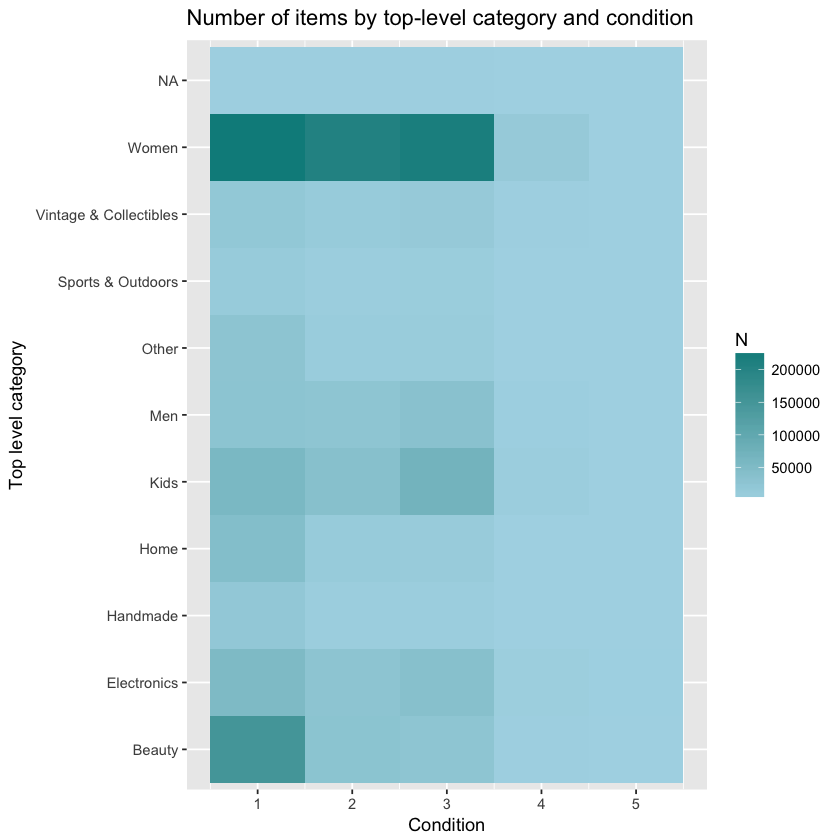

In [34]:
train[, .(.N, median_price = median(price)), by = c('level_1_cat', 'item_condition_id')] %>%
    ggplot(aes(x = item_condition_id, y = level_1_cat, fill = N)) + 
    geom_tile() + 
    scale_fill_gradient(low = 'lightblue', high = 'cyan4') + 
    labs(x = 'Condition', y = 'Top level category', title = 'Number of items by top-level category and condition')

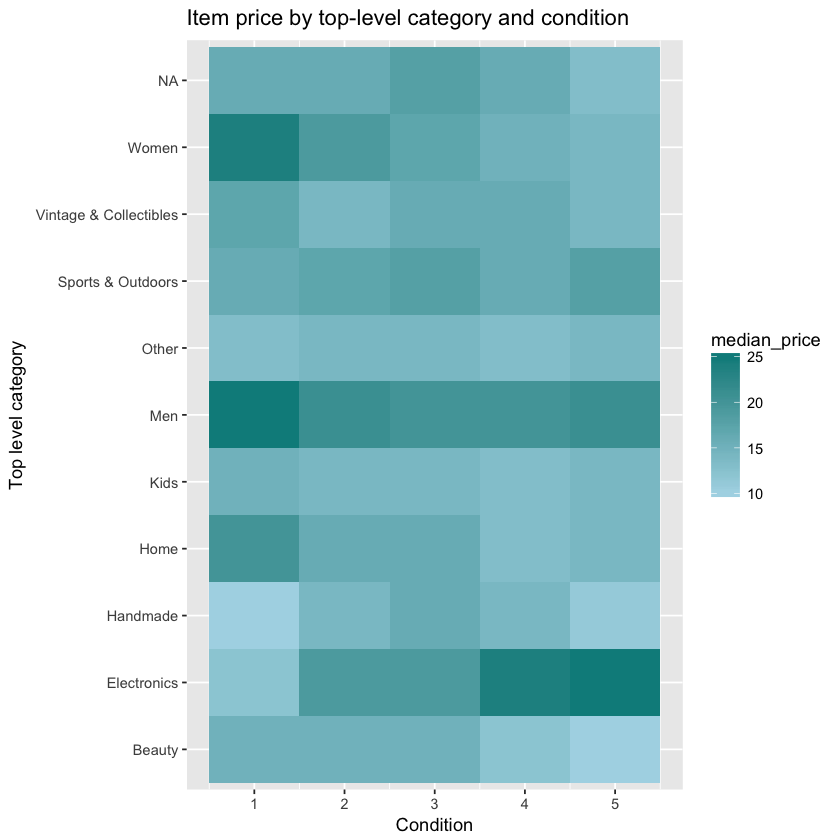

In [35]:
train[, .(median_price = median(price)), by = c('level_1_cat', 'item_condition_id')] %>%
    ggplot(aes(x = item_condition_id, y = level_1_cat, fill = median_price)) + 
    geom_tile() + 
    scale_fill_gradient(low = 'lightblue', high = 'cyan4') + 
    labs(x = 'Condition', y = 'Top level category', title = 'Item price by top-level category and condition')

# Item Description

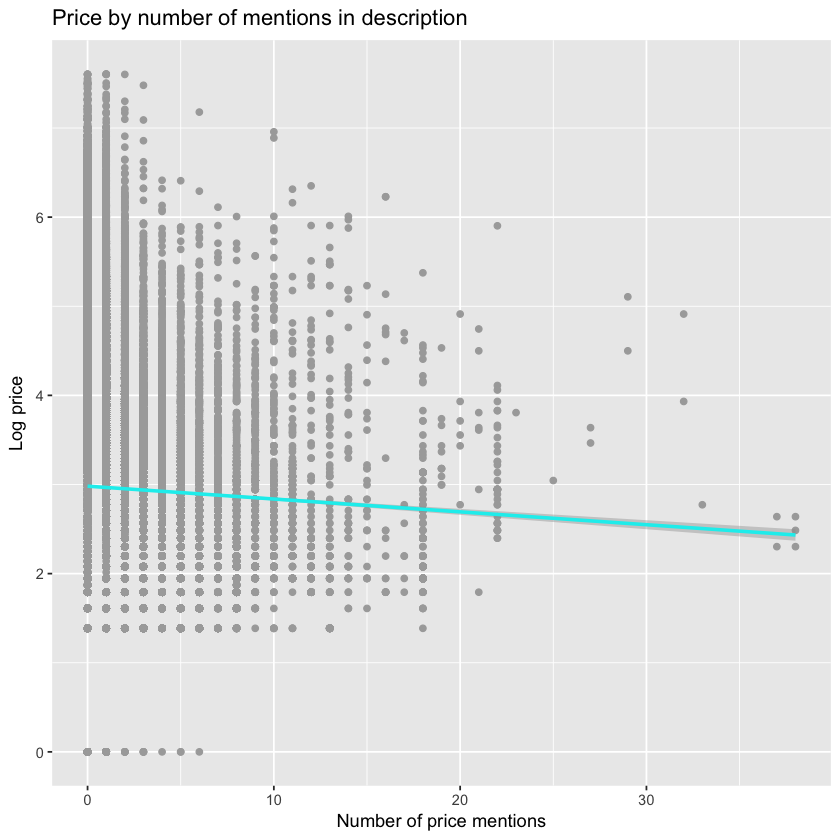

In [36]:
# Number of times price is mentioned in descritption
train[, pr_mentions := str_count(item_description, "\\[rm\\]")]

train %>%
    ggplot(aes(x = pr_mentions, y = log(price+1))) +
    geom_point(color = 'darkgrey') + 
    geom_smooth(method = 'lm', color = 'cyan2') +
    labs(x = 'Number of price mentions', y = 'Log price', title = 'Price by number of mentions in description')

In [37]:
# calculate description length
train[, desc_length := nchar(item_description)]

# set desc_length to NA where no description exists
train[item_description == 'No description yet', desc_length := NA]

cor(train$desc_length, train$price, use = 'complete.obs')

[1] 0.04417687

In [40]:
train[item_description == 'No description yet', item_description := NA]

dcorpus <- corpus(train$item_description)

summary(dcorpus)

,Text,Types,Tokens,Sentences
text1,text1,1,1,0
text2,text2,32,39,3
text3,text3,26,32,2
text4,text4,34,41,8
text5,text5,5,5,1
text6,text6,17,20,1
text7,text7,14,15,1
text8,text8,46,58,2
text9,text9,9,10,2
text10,text10,54,64,6


In [41]:
options(width = 200)
kwic(dcorpus, "Urban Outfitters", case_insensitive = FALSE) %>%
    head()

docname,from,to,pre,keyword,post


In [42]:
dfm1 <- dfm(
    dcorpus, 
    ngrams = 1, 
    remove = c("rm", stopwords("english")),
    remove_punct = TRUE,
    remove_numbers = TRUE,
    stem = TRUE)

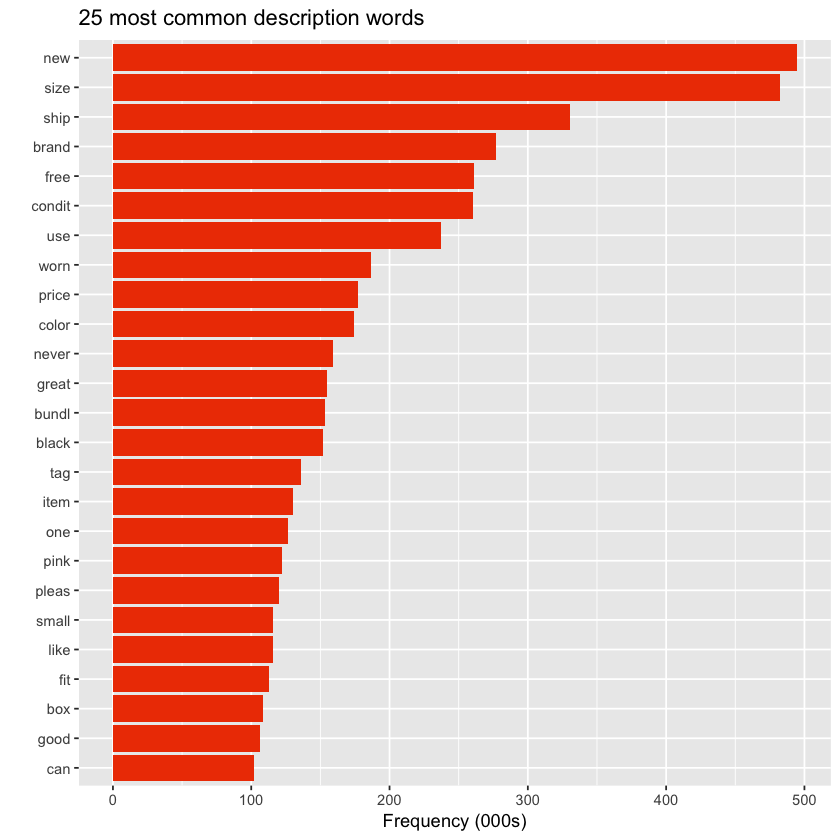

In [43]:
# get 25 most common words
tf <- topfeatures(dfm1, n = 25)

# convert to df and plot
data.frame(term = names(tf), freq = unname(tf)) %>%
    ggplot(aes(x = reorder(term, freq), y = freq/1000)) + 
    geom_bar(stat = 'identity', fill = 'orangered2') + 
    labs(x = '', y = 'Frequency (000s)', title = '25 most common description words') + 
    coord_flip()

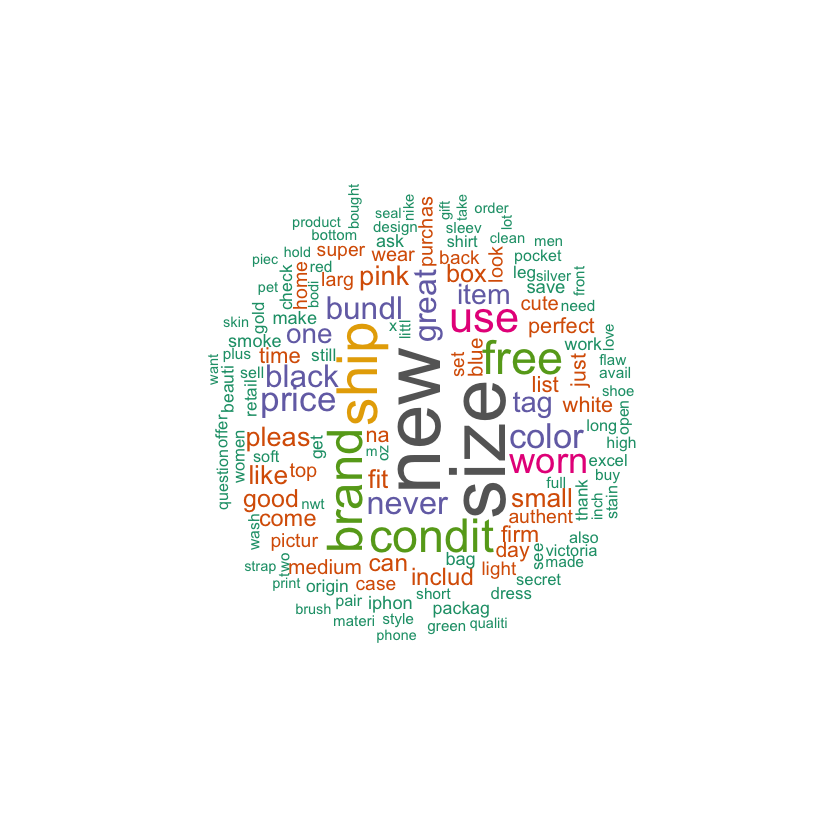

In [44]:
set.seed(100)
textplot_wordcloud(dfm1, min.freq = 3e4, random.order = FALSE,
                   rot.per = .25, 
                   colors = RColorBrewer::brewer.pal(8,"Dark2"))